# Convolutional Neural Network

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import os
import cv2
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

2024-06-09 03:45:30.338246: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data Paths

In [2]:
train_path = 'archive/seg_train/seg_train/'
test_path = 'archive/seg_test/seg_test/'

## Load Data

In [3]:
image_size = (150, 150) # 150x150 pixels

def load_images(path):
    X = []
    y = []

    folders = sorted(os.listdir(path), key=lambda x: os.path.getmtime(os.path.join(path, x)))

    for i, folder in enumerate(folders):
        for file in os.listdir(os.path.join(path, folder)):
            img = cv2.imread(os.path.join(path, folder, file))
            img = cv2.resize(img, image_size)
            X.append(img)
            y.append(i)

    return np.array(X), np.array(y)

X_train, y_train = load_images(train_path)
X_test, y_test = load_images(test_path)

## Number of Classes

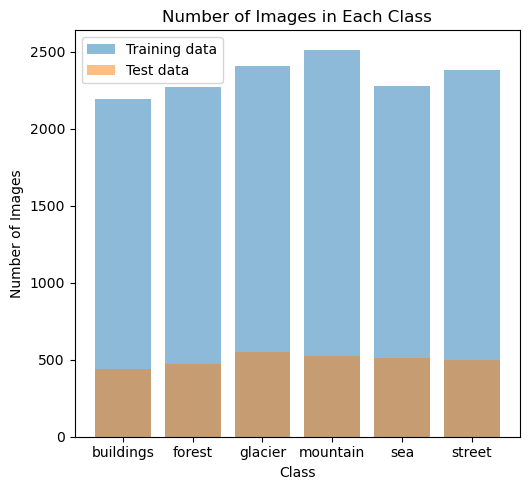

In [4]:
# plot the number if images in each class in the training and test data
labels = {0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(*np.unique(y_train, return_counts=True), label='Training data', alpha=0.5)
plt.bar(*np.unique(y_test, return_counts=True), label='Test data', alpha=0.5)
plt.title('Number of Images in Each Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(range(len(labels)), labels.values())  # Set the x-axis tick labels
plt.legend()
plt.tight_layout()
plt.show()


## Show Data

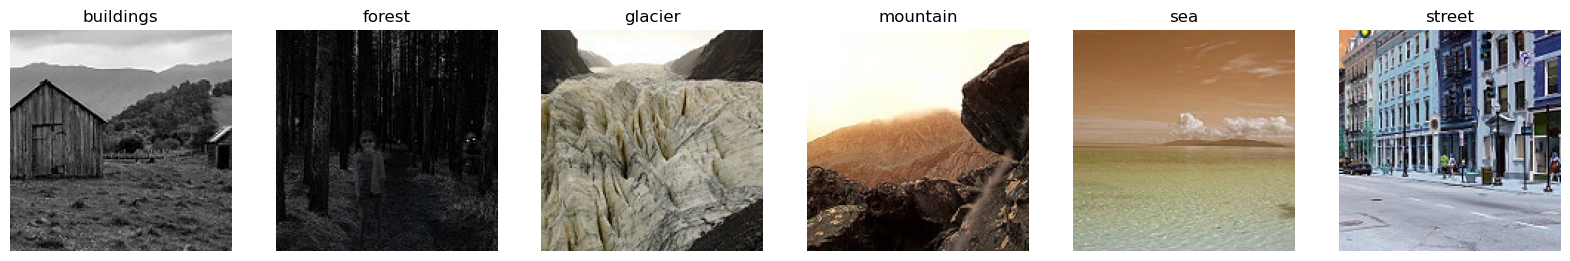

In [5]:
# display some images from the training data per class
fig, axes = plt.subplots(1, 6, figsize=(20, 20))
for i in range(6):
    axes[i].imshow(X_train[y_train == i][0])
    axes[i].set_title(labels[i])
    axes[i].axis('off')
plt.show()

## Split Training and Validation Data

In [6]:
# encode the labels
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

# one-hot encode the labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# split the training data into training and validation data
# 80% of the data will be used for training and 20% for validation
# split the data stratified by the labels
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

## Normalize Data

In [7]:
# # normal way to normalize (use this)
# X_train = X_train / 255.0
# X_val = X_val / 255.0
# X_test = X_test / 255.0

# nomalize when pc memory is not enough (...)
def normalize_data(data):
    return data / 255.0

try:
    # Normalize training data
    chunk_size = 500  # Adjust based on memory capacity
    for i in range(0, len(X_train), chunk_size):
        X_train[i:i+chunk_size] = normalize_data(X_train[i:i+chunk_size])
    
    # Normalize validation data
    for i in range(0, len(X_val), chunk_size):
        X_val[i:i+chunk_size] = normalize_data(X_val[i:i+chunk_size])
    
    # Normalize test data
    for i in range(0, len(X_test), chunk_size):
        X_test[i:i+chunk_size] = normalize_data(X_test[i:i+chunk_size])

    print("Normalization completed successfully.")
except Exception as e:
    print(f"An error occurred during normalization: {e}")

Normalization completed successfully.
Minimum value in the training data: 0
Maximum value in the training data: 1
Minimum value in the validation data: 0
Maximum value in the validation data: 1
Minimum value in the test data: 0
Maximum value in the test data: 1


## Model Architecture

In [8]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

2024-06-09 03:45:53.289115: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

## Train Model

In [9]:
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/15
  8/351 [..............................] - ETA: 3:04 - loss: 1.8057 - accuracy: 0.1992

In [ ]:
# get the accuracy of the model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, val_acc = model.evaluate(X_val, y_val, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)

print('Train accuracy:', train_acc)
print('Validation accuracy:', val_acc)
print('Test accuracy:', test_acc)

Train accuracy: 0.9586710333824158
Validation accuracy: 0.46597790718078613
Test accuracy: 0.4749999940395355
